In [1]:
# imports
%matplotlib inline
import os
import cv2
from cv2 import aruco
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import sys
code_dir = '/camp/lab/znamenskiyp/home/users/blota/code/Calibrations/ScreenCalibration/Python'
if code_dir not in sys.path:
    sys.path.append(code_dir)
import camera_calibration as camcal
import custom_aruco_markers

In [19]:
# find the data
data_root = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/blota_onix_pilote/calibration/calibrator')
save_root = Path('/camp/lab/znamenskiyp/home/shared/projects/blota_onix_pilote/')

fnames = data_root.glob('*.mp4')
vid_files = {}
for f in fnames:
    vid_files[f.stem] = f


In [14]:
def load_one_frame(fname, frame_index, return_gray=False):
    """Helper function to get one specific frame from a video file
    """
    cap = cv2.VideoCapture(str(fname))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index - 1)
    ret, frame = cap.read()
    if not ret:
        raise IOError('Could not load frame')
    
    if return_gray:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cap.release()
    return frame

def detect_aruco(frame, camera_matrix, camera_distcoeff, marker_length=50):
    
    # Get aruco dict
    #aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)  # Use 5x5 dictionary to find markers
        
    rvec_dict = {}
    tvec_dict = {}
    markerPoints_dict = {}
    if np.all(ids is not None): 
        for i in range(0, len(ids)):  
            # Estimate pose of each marker and return the values rvec and tvec---different from camera coefficients
            rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners[i], 
                                                                       marker_length, 
                                                                       camera_matrix,
                                                                       camera_distcoeff)
            (rvec - tvec).any()  # get rid of that nasty numpy value array error

            [id] = ids[i]
            rvec_dict[str(id)] = rvec
            tvec_dict[str(id)] = tvec
            markerPoints_dict[str(id)] = markerPoints
            
    return ids, rvec_dict, tvec_dict, markerPoints_dict

# Detect aruco

In [82]:
# This acquisition was too dark. Write an example frame to manually highlight the aruco
for icam in range(1,4):
    video_fname = [k for k in vid_files.keys() if 'cam%d'%icam in k]
    assert len(video_fname) == 1
    cam_fnames[icam] = video_fname[0]
    gray = load_one_frame(vid_files[cam_fnames[icam]], frame_index, return_gray=True)
    cv2.imwrite(str(save_root / ('example_frame_aruco_cam%d.png'%icam)), gray)


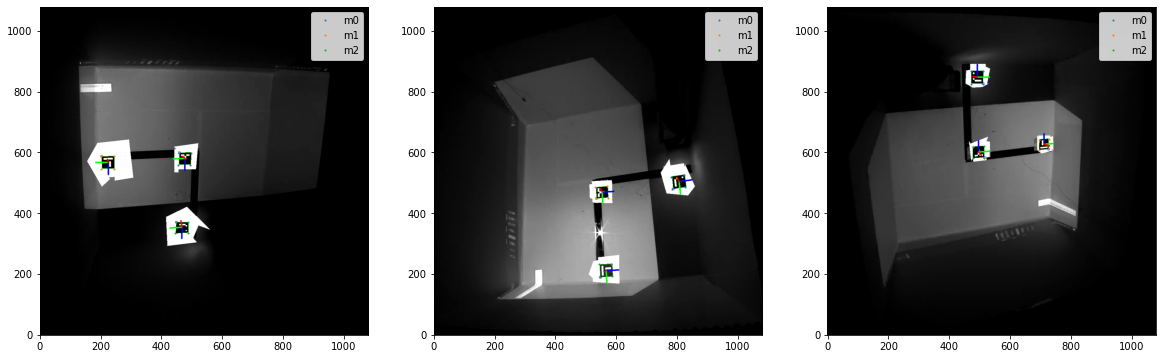

In [95]:
DRAW = True

aruco_registration = dict()
if DRAW:
    fig = plt.figure(figsize=(20,10))
frame_index = 5500
cam_fnames = dict()
for icam in range(1,4):
    drawn_file = save_root / ('example_frame_aruco_cam%d_drawn.png'%icam)
    if drawn_file.is_file():
        gray = cv2.imread(str(drawn_file))
    else:
        video_fname = [k for k in vid_files.keys() if 'cam%d'%icam in k]
        assert len(video_fname) == 1
        cam_fnames[icam] = video_fname[0]
        gray = load_one_frame(vid_files[cam_fnames[icam]], frame_index, return_gray=True)
    cam_calib = dict(np.load(save_root / ('camera_%d_calibration.npz'%icam)))

    aruco_dict = custom_aruco_markers.make_arucos(aruco_num=5, aruco_size=5)
    parameters = aruco.DetectorParameters_create()  # Marker detection parameters


    # Detect markers
    # lists of ids and the corners beloning to each id
    corners, ids, rejected_img_points = aruco.detectMarkers(gray, 
                                                            aruco_dict,
                                                            parameters=parameters,
                                                            cameraMatrix=cam_calib['mtx'], 
                                                            distCoeff=cam_calib['dist'])
    img=aruco.drawDetectedMarkers(gray, corners)  # Draw A square around the markers
    rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners, 
                                                               markerLength=50, 
                                                               cameraMatrix=cam_calib['mtx'], 
                                                               distCoeffs=cam_calib['dist'])

    aruco_in_cam = dict()
    for imark, rv in enumerate(rvec):
        tv = tvec[imark]    
        rot, _ = cv2.Rodrigues(rv)
        pts = markerPoints
        cam_pts = (rot@pts[:,0,:].T).T + tv
        aruco_in_cam[imark] = cam_pts
    aruco_registration[icam] = dict(rvec=rvec,
                                    corners=corners, 
                                    tvec=tvec, 
                                    aruco_in_cam=aruco_in_cam,
                                    cam_calib=cam_calib)
    
    # Draw if
    if DRAW:
        ax = fig.add_subplot(1,3, icam)
        corner_markers = 'osd*'
        colors = 'rgbyk'
        for ipts in range(len(corners)):
            img=aruco.drawAxis(img, 
                               cameraMatrix=cam_calib['mtx'], 
                               distCoeffs=cam_calib['dist'], 
                               rvec=rvec[ipts], 
                               tvec=tvec[ipts], 
                               length=50)  # Draw Axis
            campts, _ = cv2.projectPoints(aruco_in_cam[ipts], 
                                          rvec=np.zeros(3), 
                                          tvec=np.zeros(3), 
                                          cameraMatrix=cam_calib['mtx'], 
                                          distCoeffs=cam_calib['dist'])
            plt.plot(*campts[:,0,:].T, 'o', label='m%i'%(ipts), ms=1)

        ax.imshow(img, origin='lower')
        ax.legend()

del corners, ids, rejected_img_points, cam_calib, tvec, rvec

# Get HS points for each corner

In [96]:
def load_lighthouse(folder, take_median=True):
    fnames = folder.glob('lighthouse_matrix*.dat')
    out = {}
    for f in fnames:
        data = np.fromfile(folder / f, dtype='double')
        data = data.reshape(-1, 3)
        if take_median:
            data = np.nanmedian(data, axis=0)
        out[f.stem.split('_')[1][-1]] = data
    return out

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

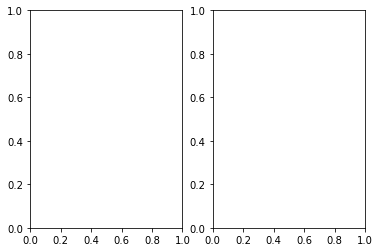

In [99]:
# check light house stability
ldata = load_lighthouse(data_root)

fig = plt.figure()
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
ax0.plot(ldata['1'][:,0,0])


In [100]:
ldata

{'1': array([ 0.53770424, -0.49478109, -2.13712694]),
 '2': array([ 0.52212182, -0.49896201, -2.13738448])}

NameError: name 'marker_df' is not defined

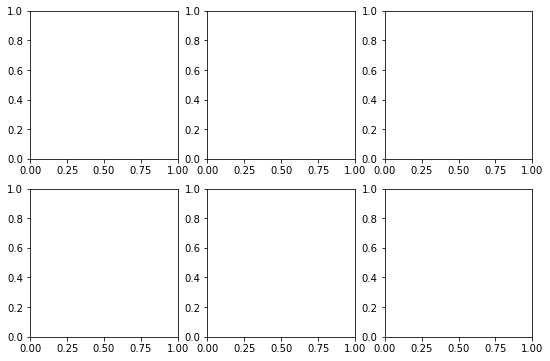

In [97]:
# check light house stability
ldata = load_lighthouse(data_root)

# accumulate all the files
data = {k:[] for k in [1,2]}
for im, (mn, series) in enumerate(marker_df.iterrows()):
    marker = series['name']
    position = series.position
    folder = data_root.glob('aruco_%s*%s*'%(marker, position))
    marker_light_pts = {'1':dict(), '2':dict()}

    for f in folder:
        _, marker_name, pos_name = f.stem.split('_')
        assert marker_name == marker
        assert pos_name == position
        ldata = load_lighthouse(f, take_median=False)
        for il in [1, 2]:
            d = ldata[str(il)]
            d = (d - np.median(d, axis=0)) * 1000.
            data[il].append(d)
# plot all together
for il in [1, 2]:
    d = np.vstack(data[il])
    for iax in range(2):
        axes[il-1, iax].hist(d[:,iax], bins=np.arange(-1.5, 1.5, 0.1), histtype='step')
    axes[il-1, 2].hist(d[:,2], bins=np.arange(-10, 10, 0.5), histtype='step')
axes[0,0].set_ylabel('Photodiode #1')
axes[1,0].set_ylabel('Photodiode #2')
lab = ['X', 'Y', 'Z']
for x in range(3):
    axes[1,x].set_xlabel('$\Delta$ measure (mm)')
    axes[0,x].set_title('%s axis' % lab[x])